## Imports

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
!pip install -U --quiet git+https://github.com/qubvel/efficientnet
import efficientnet.keras as efn
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

## Plot utils

In [ ]:
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = efn.EfficientNetB0(input_shape=IMG_SHAPE, weights='imagenet', include_top=True)

In [ ]:
def plot_image_prediction(image_path, base_model):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.resize(image, IMG_SIZE)
  image = efn.preprocess_input(image)
  image = tf.expand_dims(image, axis=0)
  decoded_pred = decode_predictions(base_model(image, training=False).numpy(), top=5)[0]
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  image_rgb = np.clip((image.numpy()*std)+mean,0,1) 
  plt.figure(figsize=(6,6))
  plt.imshow(image_rgb[0,:,:,:])
  plt.show()
  print(decoded_pred)
  return image, image_rgb

## Grad Cam

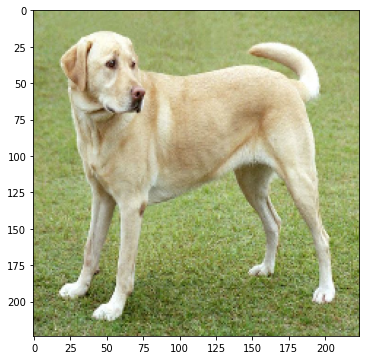

[('n02099712', 'Labrador_retriever', 0.54429686), ('n02099849', 'Chesapeake_Bay_retriever', 0.048690632), ('n02099601', 'golden_retriever', 0.035105817), ('n02115641', 'dingo', 0.017137729), ('n02091244', 'Ibizan_hound', 0.016144378)]


In [43]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image, image_rgb = plot_image_prediction(image_path, base_model)

In [44]:
base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [45]:
def get_grad_cam(image, base_model, layer_name, class_index):
  grad_model = tf.keras.models.Model([base_model.inputs], [base_model.get_layer(layer_name).output, base_model.output])

  with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image, training=False)
    predictions = predictions[:, class_index]

  grads = tape.gradient(predictions, conv_outputs)[0]
  conv_outputs = conv_outputs[0]

  gate_o = tf.cast(conv_outputs > 0 , 'float32')
  gate_g = tf.cast(grads > 0 , 'float32')

  grads = gate_o * gate_g * grads # guided gradients 
  conv_outputs = gate_o * conv_outputs # rectified outputs 

  weights = tf.reduce_mean(grads, axis=(0,1))
  cam = conv_outputs @ weights[..., tf.newaxis]

  cam = tf.image.resize(cam, size=(image.shape[1], image.shape[2]))
  cam = cam.numpy()[:,:,0]
  cam = (cam - cam.min()) / (cam.max() - cam.min()) # min max scaling cam
  return cam

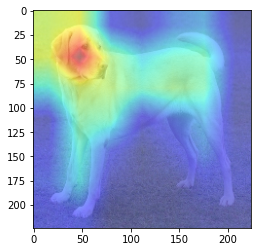

In [47]:
layer_name = 'top_activation'
class_index = 208
cam = get_grad_cam(image, base_model, layer_name, class_index)
plt.imshow(image_rgb[0], alpha=0.5)
plt.imshow(cam, alpha=0.5, cmap='jet')
plt.show()

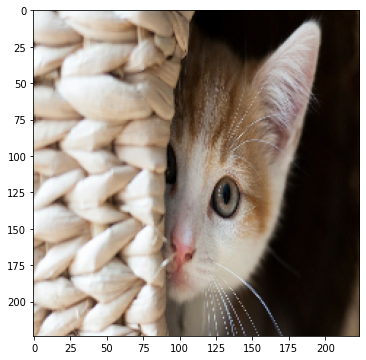

[('n02124075', 'Egyptian_cat', 0.23584852), ('n02123597', 'Siamese_cat', 0.17841676), ('n02127052', 'lynx', 0.03674596), ('n02123045', 'tabby', 0.03599156), ('n04590129', 'window_shade', 0.027559288)]


In [ ]:
image_path = tf.keras.utils.get_file('Fun_cat2.jpg', 'https://www.humanesociety.org/sites/default/files/styles/1240x698/public/2018/08/kitten-440379.jpg?h=c8d00152&itok=1fdekAh2')
image, image_rgb = plot_image_prediction(image_path, base_model)

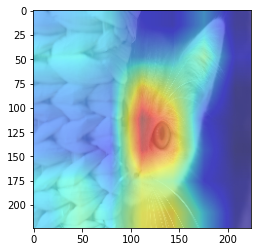

In [ ]:
layer_name = 'top_activation'
class_index = 285
cam = get_grad_cam(image, base_model, layer_name, class_index)
plt.imshow(image_rgb[0], alpha=0.5)
plt.imshow(cam, alpha=0.5, cmap='jet')
plt.show()

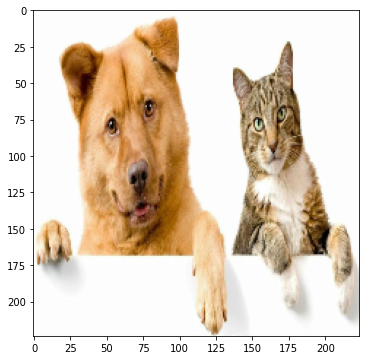

[('n02112137', 'chow', 0.3038319), ('n02123045', 'tabby', 0.12081738), ('n02123159', 'tiger_cat', 0.03576662), ('n02124075', 'Egyptian_cat', 0.026713733), ('n02129165', 'lion', 0.025041679)]


In [ ]:
url = 'https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg'
image_path = tf.keras.utils.get_file('cat_and_dog.jpg', url)
image, image_rgb = plot_image_prediction(image_path, base_model)

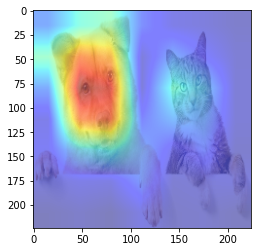

In [ ]:
layer_name = 'top_activation'
class_index = 260
cam = get_grad_cam(image, base_model, layer_name, class_index)
plt.imshow(image_rgb[0], alpha=0.5)
plt.imshow(cam, alpha=0.5, cmap='jet')
plt.show()

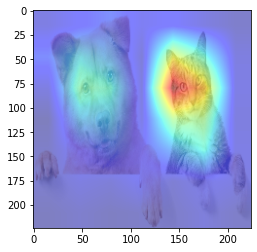

In [ ]:
layer_name = 'top_activation'
class_index = 281
cam = get_grad_cam(image, base_model, layer_name, class_index)
plt.imshow(image_rgb[0], alpha=0.5)
plt.imshow(cam, alpha=0.5, cmap='jet')
plt.show()